In [23]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers

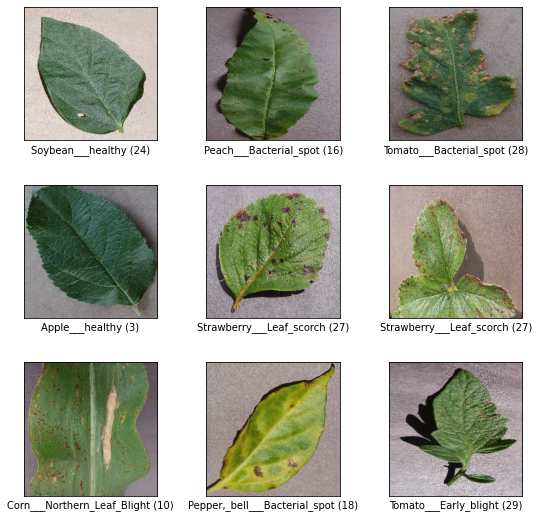

In [24]:
plant_village, plant_village_info = tfds.load('plant_village', split='train', with_info=True,shuffle_files=True,as_supervised=True)
fig = tfds.show_examples(plant_village, plant_village_info)

In [25]:
ds_size= len(plant_village)

In [26]:
classes = plant_village_info .features['label'].num_classes
print(classes)

38


In [27]:
train_size = int(0.7 * ds_size)
test_size1 = int(0.3 * ds_size)
train_dataset = plant_village.take(train_size)
test_dataset1 = plant_village.skip(train_size)
test_dataset1 = plant_village.take(test_size1)
test_size = int(0.5 * test_size1)
val_size = int(0.5 * test_size1)
test_dataset = test_dataset1.take(test_size)
test_dataset = test_dataset1.skip(test_size)
val_dataset = test_dataset1.take(val_size)

In [28]:
len(train_dataset)

38012

In [29]:
len(test_dataset)

8145

In [30]:
len(val_dataset)

8145

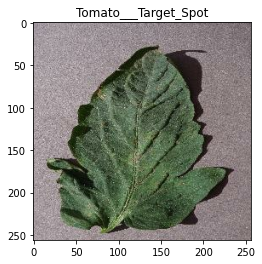

In [31]:
get_label_name = plant_village_info.features['label'].int2str

image, label = next(iter(train_dataset))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [32]:
IMG_SIZE = 299
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label


def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [33]:
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_dataset, (counter, counter)))

In [34]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [35]:
val_ds = (
    val_dataset
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_dataset
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [36]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=[299,299,3], pooling=None, classes=1000)

In [37]:
model.trainable=False

In [38]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [39]:
model2 = tf.keras.models.Sequential()

In [40]:
model2.add(model)
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(units=512, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(units=256, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(units=38, activation='softmax'))

In [41]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 38)               

In [45]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
epochs=40
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
1188/1188 [==============================] - 109s 92ms/step - loss: 0.5133 - accuracy: 0.8479 - val_loss: 0.1431 - val_accuracy: 0.9568
Epoch 2/5
1188/1188 [==============================] - 109s 92ms/step - loss: 0.5244 - accuracy: 0.8437 - val_loss: 0.1537 - val_accuracy: 0.9614
Epoch 3/5
1188/1188 [==============================] - 109s 92ms/step - loss: 0.4995 - accuracy: 0.8503 - val_loss: 0.1420 - val_accuracy: 0.9621
Epoch 4/5
1188/1188 [==============================] - 109s 92ms/step - loss: 0.5227 - accuracy: 0.8467 - val_loss: 0.1260 - val_accuracy: 0.9707
Epoch 5/5
1188/1188 [==============================] - 109s 92ms/step - loss: 0.5508 - accuracy: 0.8416 - val_loss: 0.1232 - val_accuracy: 0.9708


In [51]:
loss, acc = model2.evaluate(test_ds)
print("Accuracy", acc)

255/255 [==============================] - 21s 71ms/step - loss: 0.1225 - accuracy: 0.9731
Accuracy 0.9731123447418213


In [56]:
model2.save('inception.h5','/content/drive/MyDrive')